In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [3]:
# LeNet for MNIST using Keras and TensorFlow

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.utils import np_utils
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras import optimizers
from keras.models import load_model
np.random.seed(2)


# use GPU mem incrementally
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
# from keras import backend as K
# K.set_session(sess)


Using TensorFlow backend.


In [4]:
# import for c3d
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

In [5]:
from utils import *
from neurallogic import *
from lenet import *
from data_prepare import *
from intergrated_model import *

In [6]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 12345
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [7]:
# set global parameters
plot_epoch = 500

saved_result_data = 'result_data/marc_sim_win2.pkl'

# CE definition

In [8]:
simulation_name = 'marc_sim_win2'

############## CE definition ##############

NL_model_name = 'NL_' + simulation_name
PL_model_name = 'PNL_' + simulation_name


num_event_type = 10   # total num of unique events  3x3 + 1 unknown
num_attribute = 1      # total num of attribute (int)

ce_fsm_list = [ [1,1],[2,2],[3,3],[4,4],[5,5],[6,6],[7,7],[8,8],[9,9],[10,10]]

#                 [1,2], [3,4],[5,6],[7,8],[9,10]]
ce_time_list = [ np.array([ [INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
                np.array([[INF], [0]]),
               np.array([[INF], [0]]),
                np.array([[INF], [0]]),
#                   np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
#                 np.array([[INF], [0]]),
                np.array([[INF], [0]])
               ]

event_num = 100000
window_size = 2

# Training Neural Logic Models

In [9]:
train_neurallogic_model(NL_model_name,
                            num_event_type, num_attribute,
                            ce_fsm_list, ce_time_list,
                            window_size,
                            event_num ,
                            verify_logic = False,
                            diagnose = True)

NeuralLogic model exists in:  saved_model/NL_marc_sim_win2.hdf5


In [10]:
# Returns a compiled model identical to the previous one
loading_path = 'saved_model/'+NL_model_name+'.hdf5'
neuralLogic_model = load_model(loading_path)
neuralLogic_model.name="neurallogic"
print('Loading model successfully from ', loading_path)

Loading model successfully from  saved_model/NL_marc_sim_win2.hdf5


# Preparing all dataset required

In [11]:
mnist_event_num = 100000

In [12]:
mnist_data_event_path = PL_model_name+'_data_' + str(mnist_event_num) +'.npz'
mnist_data_event, data_feature, data_label = generate_mnist_event_data(num_event_type, num_attribute, 
                                                                          ce_fsm_list, ce_time_list,
                                                                          mnist_event_num, window_size,
                                                                          mnist_data_event_path)

Data file exists in:  data/PNL_marc_sim_win2_data_100000.npz


In [13]:
if np.ndim(data_label)==1:
    data_label = np.expand_dims(data_label, axis = 1)

# valid_index = (data_label!= 999)# choose valid data samples
valid_index = (data_label.sum(axis = 1)!= 999)
v_mnist_data_event  =  mnist_data_event[valid_index, ]
v_data_label = data_label[valid_index, ]
print('Valid data (with valid CE) shape: ')
print("Data:\t", v_mnist_data_event.shape)
print("Label:\t", v_data_label.shape)

Valid data (with valid CE) shape: 
Data:	 (99999, 2, 28, 28, 1)
Label:	 (99999, 10)


In [14]:
# prepare the testing MNIST dataset for customized LeNet
mnist_label = list(range(num_event_type)) # 
mnist_x_test, mnist_y_test = generate_customized_mnist_data(mnist_label, num_event_type)

Testing mnist feature shape:  (10000, 28, 28, 1)
Testing mnist label shape:  (10000, 10)


In [15]:
v_mnist_data_event = v_mnist_data_event *2 -1
mnist_x_test = mnist_x_test *2 -1

# 1.Training in end2end fashion:
### MSE loss + Adam(0.001)
### Combined loss doesn't work really well, stucked at local minima

In [16]:
# generate a new LeNet model from scratch
lenetModel = LeNet_mnist(num_output = num_event_type)  # 2 events
lenetModel.name="lenetModel"
score = lenetModel.evaluate(mnist_x_test, mnist_y_test, verbose=1)
print('Test loss: %3f,  \t \tTest Accuracy: %4f'%(score[0], score[1]))

final_model = intergrated_model(lenetModel, neuralLogic_model, 
                                window_size, num_event_type,
                                omega_value = 1e-4,
                                load_nl_weights = True,
                                nl_trainable = False,
#                                 loss = 'combined_loss',  # use semantic loss here
                                loss = 'mse_loss',  # use semantic loss here
                                diagnose = False)
# loss = combined_loss / mse_loss

10000/10000 [==============================] - 2s 221us/step
Test loss: 2.341936,  	 	Test Accuracy: 0.083400
Model input:  Tensor("input_1:0", shape=(None, 2, 28, 28, 1), dtype=float32)
Model output:  Tensor("dense_3/BiasAdd:0", shape=(None, 10), dtype=float32)

===== NL model weights loaded =====

===== Neural Logic module freezed.=====

===== Loss Func: MSE =====


In [17]:
plot_epoch = 500
epochs = plot_epoch
diagnose = True

save_path = 'saved_model/'+ PL_model_name +'.hdf5'
es = EarlyStopping(monitor='val_MAE', mode='min', verbose=1, patience=plot_epoch)
mc = ModelCheckpoint(save_path, monitor='val_MAE', mode='min', verbose=diagnose, save_best_only=True)
cb_list = [es, mc]

print('The maximum training epochs is: ', epochs)
H = final_model.fit( v_mnist_data_event ,v_data_label, 
#                         batch_size = 32, 
                        batch_size = 256, 
                        epochs = epochs,
                        verbose=diagnose,
                        shuffle=True,
                        callbacks=cb_list,
                        validation_data = (v_mnist_data_event ,v_data_label) )
#                         validation_split = 0.2)

hist_NL = H

The maximum training epochs is:  500
Train on 99999 samples, validate on 99999 samples
Epoch 1/500
99999/99999 [==============================] - 10s 98us/step - loss: 0.0096 - MAE: 0.0265 - val_loss: 0.0086 - val_MAE: 0.0252

Epoch 00001: val_MAE improved from inf to 0.02515, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 2/500
99999/99999 [==============================] - 9s 90us/step - loss: 0.0086 - MAE: 0.0246 - val_loss: 0.0085 - val_MAE: 0.0244

Epoch 00002: val_MAE improved from 0.02515 to 0.02442, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 3/500
99999/99999 [==============================] - 9s 91us/step - loss: 0.0085 - MAE: 0.0241 - val_loss: 0.0084 - val_MAE: 0.0237

Epoch 00003: val_MAE improved from 0.02442 to 0.02372, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 4/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0084 - MAE: 0.0239 - val_loss: 0.0084 - val_MAE: 0.0241

Epoch 00004: val_MAE did not improve from 


Epoch 00042: val_MAE did not improve from 0.02302
Epoch 43/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0082 - MAE: 0.0240 - val_loss: 0.0082 - val_MAE: 0.0241

Epoch 00043: val_MAE did not improve from 0.02302
Epoch 44/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0082 - MAE: 0.0240 - val_loss: 0.0082 - val_MAE: 0.0237

Epoch 00044: val_MAE did not improve from 0.02302
Epoch 45/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0082 - MAE: 0.0240 - val_loss: 0.0082 - val_MAE: 0.0241

Epoch 00045: val_MAE did not improve from 0.02302
Epoch 46/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0082 - MAE: 0.0241 - val_loss: 0.0082 - val_MAE: 0.0236

Epoch 00046: val_MAE did not improve from 0.02302
Epoch 47/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0082 - MAE: 0.0241 - val_loss: 0.0082 - val_MAE: 0.0240

Epoch 00047: val_MAE did not improve from 0.02302

99999/99999 [==============================] - 9s 85us/step - loss: 0.0081 - MAE: 0.0237 - val_loss: 0.0081 - val_MAE: 0.0235

Epoch 00086: val_MAE did not improve from 0.02302
Epoch 87/500
99999/99999 [==============================] - 9s 87us/step - loss: 0.0081 - MAE: 0.0239 - val_loss: 0.0081 - val_MAE: 0.0238

Epoch 00087: val_MAE did not improve from 0.02302
Epoch 88/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0081 - MAE: 0.0236 - val_loss: 0.0081 - val_MAE: 0.0232

Epoch 00088: val_MAE did not improve from 0.02302
Epoch 89/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0081 - MAE: 0.0235 - val_loss: 0.0080 - val_MAE: 0.0233

Epoch 00089: val_MAE did not improve from 0.02302
Epoch 90/500
99999/99999 [==============================] - 9s 91us/step - loss: 0.0080 - MAE: 0.0235 - val_loss: 0.0081 - val_MAE: 0.0238

Epoch 00090: val_MAE did not improve from 0.02302
Epoch 91/500
99999/99999 [==============================] - 9s 

99999/99999 [==============================] - 9s 92us/step - loss: 0.0080 - MAE: 0.0230 - val_loss: 0.0080 - val_MAE: 0.0228

Epoch 00128: val_MAE did not improve from 0.02233
Epoch 129/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0080 - MAE: 0.0231 - val_loss: 0.0080 - val_MAE: 0.0233

Epoch 00129: val_MAE did not improve from 0.02233
Epoch 130/500
99999/99999 [==============================] - 9s 95us/step - loss: 0.0080 - MAE: 0.0229 - val_loss: 0.0080 - val_MAE: 0.0230

Epoch 00130: val_MAE did not improve from 0.02233
Epoch 131/500
99999/99999 [==============================] - 9s 95us/step - loss: 0.0080 - MAE: 0.0228 - val_loss: 0.0080 - val_MAE: 0.0227

Epoch 00131: val_MAE did not improve from 0.02233
Epoch 132/500
99999/99999 [==============================] - 9s 90us/step - loss: 0.0080 - MAE: 0.0228 - val_loss: 0.0080 - val_MAE: 0.0227

Epoch 00132: val_MAE did not improve from 0.02233
Epoch 133/500
99999/99999 [==============================] 

99999/99999 [==============================] - 9s 90us/step - loss: 0.0079 - MAE: 0.0221 - val_loss: 0.0079 - val_MAE: 0.0220

Epoch 00169: val_MAE did not improve from 0.02188
Epoch 170/500
99999/99999 [==============================] - 9s 88us/step - loss: 0.0079 - MAE: 0.0221 - val_loss: 0.0079 - val_MAE: 0.0219

Epoch 00170: val_MAE did not improve from 0.02188
Epoch 171/500
99999/99999 [==============================] - 9s 91us/step - loss: 0.0079 - MAE: 0.0222 - val_loss: 0.0079 - val_MAE: 0.0220

Epoch 00171: val_MAE did not improve from 0.02188
Epoch 172/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0079 - MAE: 0.0223 - val_loss: 0.0079 - val_MAE: 0.0225

Epoch 00172: val_MAE did not improve from 0.02188
Epoch 173/500
99999/99999 [==============================] - 8s 85us/step - loss: 0.0079 - MAE: 0.0221 - val_loss: 0.0079 - val_MAE: 0.0219

Epoch 00173: val_MAE did not improve from 0.02188
Epoch 174/500
99999/99999 [==============================] 

99999/99999 [==============================] - 9s 93us/step - loss: 0.0043 - MAE: 0.0094 - val_loss: 0.0043 - val_MAE: 0.0101

Epoch 00248: val_MAE did not improve from 0.00925
Epoch 249/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0043 - MAE: 0.0095 - val_loss: 0.0043 - val_MAE: 0.0089

Epoch 00249: val_MAE improved from 0.00925 to 0.00895, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 250/500
99999/99999 [==============================] - 9s 90us/step - loss: 0.0043 - MAE: 0.0093 - val_loss: 0.0043 - val_MAE: 0.0087

Epoch 00250: val_MAE improved from 0.00895 to 0.00866, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 251/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0043 - MAE: 0.0091 - val_loss: 0.0043 - val_MAE: 0.0098

Epoch 00251: val_MAE did not improve from 0.00866
Epoch 252/500
99999/99999 [==============================] - 9s 91us/step - loss: 0.0044 - MAE: 0.0090 - val_loss: 0.0043 - val_MAE: 0.008


Epoch 00286: val_MAE did not improve from 0.00570
Epoch 287/500
99999/99999 [==============================] - 9s 88us/step - loss: 0.0044 - MAE: 0.0059 - val_loss: 0.0045 - val_MAE: 0.0058

Epoch 00287: val_MAE did not improve from 0.00570
Epoch 288/500
99999/99999 [==============================] - 9s 87us/step - loss: 0.0045 - MAE: 0.0060 - val_loss: 0.0043 - val_MAE: 0.0057

Epoch 00288: val_MAE improved from 0.00570 to 0.00568, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 289/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0044 - MAE: 0.0057 - val_loss: 0.0044 - val_MAE: 0.0058

Epoch 00289: val_MAE did not improve from 0.00568
Epoch 290/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0044 - MAE: 0.0058 - val_loss: 0.0043 - val_MAE: 0.0057

Epoch 00290: val_MAE improved from 0.00568 to 0.00565, saving model to saved_model/PNL_marc_sim_win2.hdf5
Epoch 291/500
99999/99999 [==============================] - 9s 93us/step


Epoch 00327: val_MAE did not improve from 0.00528
Epoch 328/500
99999/99999 [==============================] - 9s 91us/step - loss: 0.0048 - MAE: 0.0054 - val_loss: 0.0049 - val_MAE: 0.0056

Epoch 00328: val_MAE did not improve from 0.00528
Epoch 329/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0050 - MAE: 0.0057 - val_loss: 0.0054 - val_MAE: 0.0061

Epoch 00329: val_MAE did not improve from 0.00528
Epoch 330/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0052 - MAE: 0.0059 - val_loss: 0.0049 - val_MAE: 0.0055

Epoch 00330: val_MAE did not improve from 0.00528
Epoch 331/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0052 - MAE: 0.0059 - val_loss: 0.0055 - val_MAE: 0.0063

Epoch 00331: val_MAE did not improve from 0.00528
Epoch 332/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0051 - MAE: 0.0057 - val_loss: 0.0050 - val_MAE: 0.0056

Epoch 00332: val_MAE did not improve from 0.


Epoch 00370: val_MAE did not improve from 0.00528
Epoch 371/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0056 - MAE: 0.0060 - val_loss: 0.0059 - val_MAE: 0.0062

Epoch 00371: val_MAE did not improve from 0.00528
Epoch 372/500
99999/99999 [==============================] - 9s 94us/step - loss: 0.0058 - MAE: 0.0061 - val_loss: 0.0060 - val_MAE: 0.0063

Epoch 00372: val_MAE did not improve from 0.00528
Epoch 373/500
99999/99999 [==============================] - 9s 94us/step - loss: 0.0056 - MAE: 0.0059 - val_loss: 0.0057 - val_MAE: 0.0061

Epoch 00373: val_MAE did not improve from 0.00528
Epoch 374/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0057 - MAE: 0.0060 - val_loss: 0.0066 - val_MAE: 0.0071

Epoch 00374: val_MAE did not improve from 0.00528
Epoch 375/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0058 - MAE: 0.0061 - val_loss: 0.0058 - val_MAE: 0.0061

Epoch 00375: val_MAE did not improve from 0.


Epoch 00413: val_MAE did not improve from 0.00528
Epoch 414/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0072 - MAE: 0.0074 - val_loss: 0.0080 - val_MAE: 0.0082

Epoch 00414: val_MAE did not improve from 0.00528
Epoch 415/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0077 - MAE: 0.0078 - val_loss: 0.0072 - val_MAE: 0.0073

Epoch 00415: val_MAE did not improve from 0.00528
Epoch 416/500
99999/99999 [==============================] - 8s 83us/step - loss: 0.0074 - MAE: 0.0075 - val_loss: 0.0075 - val_MAE: 0.0077

Epoch 00416: val_MAE did not improve from 0.00528
Epoch 417/500
99999/99999 [==============================] - 8s 84us/step - loss: 0.0071 - MAE: 0.0072 - val_loss: 0.0072 - val_MAE: 0.0073

Epoch 00417: val_MAE did not improve from 0.00528
Epoch 418/500
99999/99999 [==============================] - 9s 85us/step - loss: 0.0074 - MAE: 0.0075 - val_loss: 0.0079 - val_MAE: 0.0080

Epoch 00418: val_MAE did not improve from 0.


Epoch 00456: val_MAE did not improve from 0.00528
Epoch 457/500
99999/99999 [==============================] - 9s 94us/step - loss: 0.0067 - MAE: 0.0068 - val_loss: 0.0075 - val_MAE: 0.0075

Epoch 00457: val_MAE did not improve from 0.00528
Epoch 458/500
99999/99999 [==============================] - 9s 89us/step - loss: 0.0067 - MAE: 0.0068 - val_loss: 0.0069 - val_MAE: 0.0069

Epoch 00458: val_MAE did not improve from 0.00528
Epoch 459/500
99999/99999 [==============================] - 9s 91us/step - loss: 0.0064 - MAE: 0.0064 - val_loss: 0.0060 - val_MAE: 0.0060

Epoch 00459: val_MAE did not improve from 0.00528
Epoch 460/500
99999/99999 [==============================] - 9s 92us/step - loss: 0.0060 - MAE: 0.0060 - val_loss: 0.0057 - val_MAE: 0.0057

Epoch 00460: val_MAE did not improve from 0.00528
Epoch 461/500
99999/99999 [==============================] - 9s 93us/step - loss: 0.0057 - MAE: 0.0057 - val_loss: 0.0052 - val_MAE: 0.0052

Epoch 00461: val_MAE improved from 0.00528 t

# moniter the lenet performance 

In [18]:
lenet_score1 = lenetModel.evaluate(mnist_x_test, mnist_y_test, verbose=0)
# print('Test loss: %3f,  \t \tTest Accuracy: %4f'%(lenet_score1[0], lenet_score1[1]))
print('Proposed acc:\t %4f'%(lenet_score1[1]))
# lenet_score2 = lenetModel_2.evaluate(mnist_x_test, mnist_y_test, verbose=0)
# print('Ablation acc:\t %4f'%(lenet_score2[1]))

Proposed acc:	 0.774300


dict_keys(['val_loss', 'val_MAE', 'loss', 'MAE'])


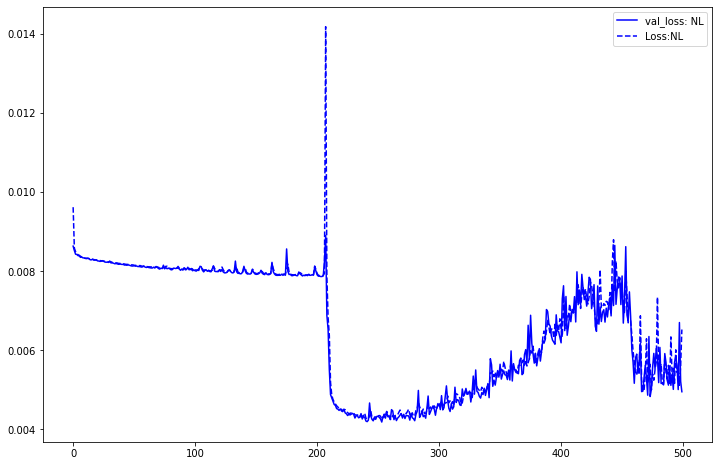

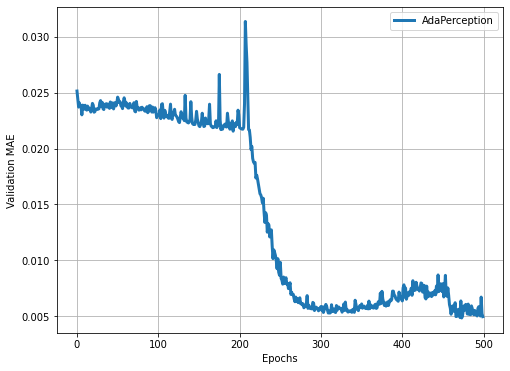

In [19]:
# evaluation: plot the learning curves
hist_NL = H
hist1 = hist_NL.history
print(hist1.keys() )

import matplotlib.pyplot as plt
# # loss figure
fig = plt.figure(figsize=(12,8))
plt.plot(hist1['val_loss'], 'b-')
plt.plot(hist1['loss'], 'b--')
plt.legend(['val_loss: NL', 'Loss:NL', 'val_loss', 'Loss'])
plt.show()

# MAE figure
fig = plt.figure(figsize=(8, 6))
plt.plot(hist1['val_MAE'], '-', linewidth=3)
# plt.plot(hist2['val_MAE'], '-', linewidth=3)
# plt.plot(hist3['val_MAE'], '-', linewidth=3)
# plt.plot(hist4['val_mae'], '-', linewidth=3)

# plt.plot(hist1['MAE'], '-')
# plt.plot(hist2['MAE'], '-')
# plt.plot(hist3['MAE'], '-')
# plt.plot(hist4['mae'], '-')

plt.legend(['AdaPerception', 'AdaPerception w/o L_semantic', 'Training from scratch', 'C3D model'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.savefig('filename.png', dpi=600)
plt.show()
